## Задание № 6

### Урок 6. Градиентный бустинг (AdaBoost)

#### Задание

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.
2. **(*)** Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.
3. **(*)** Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

>Напишем реализацию градиентного бустинга на основе объектов.

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np
from abc import ABC, abstractmethod

> Функция потерь реализованая как гипер-параметр

In [55]:
# Абстрактный класс функции потерь
class FuncLoss(ABC):
    @abstractmethod
    def loss(self, real, prediction):
        pass

    @abstractmethod
    def grad(self, x, y):
        pass

> Класс градиентного бустинга с инкапсуляцией всех зависимостей и параметров

In [60]:
# класс реализации градиентного бустинга
class GBGradBoost:
    n_trees = 0
    max_depth = 0
    eta = 0
    coefs = []

    X_train = None
    X_test = None
    y_train = None
    y_test = None
    trees_list = []

    train_errors = []
    test_errors = []

    func_loss = None

    # обучающая выборка с классами и функция потерь - обязательные параметры
    def __init__(self, X, y, func_loss: FuncLoss, n_trees=10, max_depth=3, test_size=0.25, eta=1):

        self.params(n_trees=n_trees, max_depth=max_depth, eta=eta)
        # разделение выборки встроено в класс
        self.X_train, self.X_test, self.y_train, self.y_test = model_selection.train_test_split(X, y,
                                                                                                test_size=test_size,
                                                                                                random_state=42)
        self.func_loss = func_loss

    # установка гипер-параметров
    def params(self, n_trees=10, max_depth=3, eta=1):
        self.coefs = [1] * n_trees
        self.trees_list = []
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.eta = eta

    def gb_predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
        # прибавляются с шагом eta
        return np.array(
            [sum([self.eta * coef * alg.predict([x])[0] for alg, coef in zip(self.trees_list, self.coefs)]) for x in X])

    def calc_error(self):
        # расчет ошибки на обучающей и тестовой выборке
        self.train_errors.append(self.func_loss.loss(self.y_train, self.gb_predict(self.X_train)))
        self.test_errors.append(self.func_loss.loss(self.y_test, self.gb_predict(self.X_test)))

    def gb_fit(self):
        # Деревья будем записывать в список
        self.trees_list = []

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        self.train_errors = []
        self.test_errors = []

        for i in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees_list) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(self.X_train, self.y_train)

                self.calc_error()
            else:
                # Получим ответы на текущей композиции
                target = self.gb_predict(self.X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(self.X_train, self.func_loss.grad(self.y_train, target))

                self.calc_error()

            self.trees_list.append(tree)

    def evaluate_alg(self):
        train_prediction = self.gb_predict(self.X_train)
        error_train = self.func_loss.loss(self.y_train, train_prediction)

        test_prediction = self.gb_predict(self.X_test)
        error_test = self.func_loss.loss(self.y_test, test_prediction)
        return error_train, error_test

    def evaluate_alg_print(self):
        error_train, error_test = self.evaluate_alg()
        print(f'Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тренировочной выборке: {error_train}')

        print(f'Ошибка алгоритма из {self.n_trees} деревьев глубиной {self.max_depth} \
        с шагом {self.eta} на тестовой выборке: {error_test}')

> Конкретная реализация функционала потерь - среднее квадратичное
>, а также градиент

In [61]:
class FlossMSqured(FuncLoss):
    # mean_squared_error
    def loss(self, real, prediction):
        return (sum((real - prediction) ** 2)) / len(real)

    def grad(self, y, z):
        return (y - z)

Загрузим данные
https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

In [62]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)

> Проведем первый прогон

In [65]:
gbgboost = GBGradBoost(X, y, FlossMSqured(), eta=0.1, max_depth=3, n_trees=10)
gbgboost.gb_fit()
gbgboost.evaluate_alg_print()

Ошибка алгоритма из 10 деревьев глубиной 3         с шагом 0.1 на тренировочной выборке: 5888.818429652217
Ошибка алгоритма из 10 деревьев глубиной 3         с шагом 0.1 на тестовой выборке: 5590.496579163249


In [70]:
ex = []
for depth in [3, 5, 10]:
    for n_trees in [10, 20, 50, 100]:
        gbgboost.params(n_trees=n_trees, max_depth=depth, eta=0.1)
        gbgboost.gb_fit()
        error_train, error_test =  gbgboost.evaluate_alg()
        ex.append((depth, n_trees, error_train, error_test))
ex

[(3, 10, 5888.818429652217, 5590.496579163249),
 (3, 20, 2510.4218417335132, 3198.219867547023),
 (3, 50, 1396.1003671665405, 3092.734712112894),
 (3, 100, 905.4545496015852, 3209.200884210777),
 (5, 10, 4903.664793653586, 5776.780425725318),
 (5, 20, 1320.0647658513283, 3653.4023490333116),
 (5, 50, 272.56479292678364, 3762.8440317377504),
 (5, 100, 67.4589749216229, 3900.8282633542785),
 (10, 10, 3717.875567797273, 6111.894087838001),
 (10, 20, 461.8546925586901, 4248.008749244859),
 (10, 50, 0.9523817424864434, 4264.018393306343),
 (10, 100, 3.6748558713872416e-05, 4278.172302957978)]

In [91]:
m = list(zip(*ex))

[(3, 3, 3, 3, 5, 5, 5, 5, 10, 10, 10, 10),
 (10, 20, 50, 100, 10, 20, 50, 100, 10, 20, 50, 100),
 (5888.818429652217,
  2510.4218417335132,
  1396.1003671665405,
  905.4545496015852,
  4903.664793653586,
  1320.0647658513283,
  272.56479292678364,
  67.4589749216229,
  3717.875567797273,
  461.8546925586901,
  0.9523817424864434,
  3.6748558713872416e-05),
 (5590.496579163249,
  3198.219867547023,
  3092.734712112894,
  3209.200884210777,
  5776.780425725318,
  3653.4023490333116,
  3762.8440317377504,
  3900.8282633542785,
  6111.894087838001,
  4248.008749244859,
  4264.018393306343,
  4278.172302957978)]

C:\Users\8523~1\AppData\Local\Temp/ipykernel_33176/31138506.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


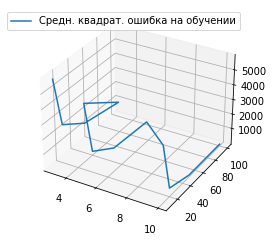

C:\Users\8523~1\AppData\Local\Temp/ipykernel_33176/31138506.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


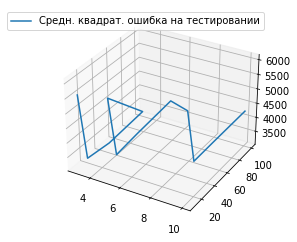

In [89]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
z = m[2]
x = m[0]
y = m[1]
ax.plot(x, y, z, label='Средн. квадрат. ошибка на обучении')
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
z = m[3]
x = m[0]
y = m[1]
ax.plot(x, y, z, label='Средн. квадрат. ошибка на тестировании')
ax.legend()
plt.show()


> Зависимость носит сложный нелинейный характер. При анализе ошибки необходимо учитывать переобучение.
> Хорошие результаты бустинг показал при количестве деревьев 50 и глубине 3. При этом ошибки при обучении и тестировании
> минимальны.


